# Applying Data Science Model Development (XGboost)

## 1. Preprocess the data

In [2]:
# Install Optuna package ready for hyperparameter tuning
pip install optuna

SyntaxError: invalid syntax (2971386439.py, line 2)

In [1]:
# === Step 0: Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
import optuna
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# === Step 1: Data Preparation ===
# Load the data (train, validate, and test)
df = pd.read_csv("Final_v2_processed.csv") 
test_df = pd.read_csv("Final_test_v2_processed.csv")

# List of columns to be removed
columns_to_remove = ["recoveries", "last_fico_range_high", "last_fico_range_low", "debt_settlement_flag"]

# Remove the specified column
df = df.drop(columns=columns_to_remove, errors='ignore')  
test_df = test_df.drop(columns=columns_to_remove, errors='ignore')

# Need to handle the state variable - convert state names to numbers
# The LabelEncoder transforms categorical data into numerical values
le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"]) 
test_df["addr_state"] = le.fit_transform(test_df["addr_state"])

# Define our features and target variable
target_col = "loan_status"
feature_cols = [col for col in df.columns if col != target_col and col != "id"]

# Converting to numpy arrays for faster processing
X = df[feature_cols].values
y = df[target_col].values
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# No need to reshape for XGBoost because it works with 2D data: [n_samples, n_features]

# Creating XGBoost's specialized data structure - DMatrix
# This format is optimized for the XGBoost algorithm and improves performance
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

## 2. Hyperparameter Tuning

In [3]:
# === Step 2: Optuna Hyperparameter Tuning ===
def objective(trial):
    # Define the hyperparameters to search through to find the best configuration for our data
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']), # Tree type to use
        'max_depth': trial.suggest_int('max_depth', 3, 10), # How deep should trees be?
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), # Number of trees to build
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), # Fraction of samples used for fitting trees
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), # Fraction of features used per tree
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True), # L1 regularisation
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True), # L2 regularisation
    }
    
    # Storage for evaluation results
    evals_result = {}
    
    # Train a model with the current trial's parameters
    model = xgb.train(
        param,
        dtrain,
        num_boost_round=100, # Max number of trees
        evals=[(dval, 'validation')], # Dataset to evaluate on
        early_stopping_rounds=10, # Stop if no improvement after 10 rounds
        evals_result=evals_result,
        verbose_eval=False # Don't print evaluation results for each iteration
    )
    
    # Get best score
    preds = model.predict(dval)
    y_pred_binary = [1 if pred > 0.5 else 0 for pred in preds]
    f1 = f1_score(y_val, y_pred_binary, average="weighted")
    
    return 1 - f1  # Optuna minimizes, so we use 1 - F1

# Run Optuna
study = optuna.create_study()
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

[I 2025-04-28 16:41:30,286] A new study created in memory with name: no-name-509f66e9-42ef-4241-94b3-91761b934153
[I 2025-04-28 16:41:31,195] Trial 0 finished with value: 0.24116101152885172 and parameters: {'booster': 'gbtree', 'max_depth': 7, 'learning_rate': 0.011416009287305236, 'n_estimators': 67, 'min_child_weight': 1, 'gamma': 0.0002811621809630175, 'subsample': 0.851262460733271, 'colsample_bytree': 0.6983371925194775, 'reg_alpha': 3.282664365985104e-05, 'reg_lambda': 3.315109617775208e-05}. Best is trial 0 with value: 0.24116101152885172.
[I 2025-04-28 16:41:33,607] Trial 1 finished with value: 0.24116101152885172 and parameters: {'booster': 'dart', 'max_depth': 6, 'learning_rate': 0.013187743619520966, 'n_estimators': 77, 'min_child_weight': 9, 'gamma': 8.202893259964105e-06, 'subsample': 0.7911675401517001, 'colsample_bytree': 0.7783383179816525, 'reg_alpha': 1.948795659516708e-06, 'reg_lambda': 0.0011322280377971598}. Best is trial 0 with value: 0.24116101152885172.
[I 2025

Best hyperparameters: {'booster': 'gbtree', 'max_depth': 10, 'learning_rate': 0.2982418830890847, 'n_estimators': 325, 'min_child_weight': 5, 'gamma': 1.0636311391587055e-08, 'subsample': 0.8566825779333512, 'colsample_bytree': 0.5034906804880019, 'reg_alpha': 0.002937094091256337, 'reg_lambda': 1.8393631557453043e-08}


## 3. Re-learn with the optimized parameters

In [4]:
# === Step 3: Train Final Model with Best Params ===
# Extract parameters from best trial
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': best_params['booster'],
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'min_child_weight': best_params['min_child_weight'],
    'gamma': best_params['gamma'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
}

# Initialise lists to track model performance during training
evals_result = {}

# Train the final model with the best parameters we found
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=best_params['n_estimators'],
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)

# Save the model
joblib.dump(final_model, "xgboost_credit_default_model.pkl")


[0]	train-auc:0.71465	validation-auc:0.67292
[1]	train-auc:0.74919	validation-auc:0.69001
[2]	train-auc:0.76481	validation-auc:0.69377
[3]	train-auc:0.77277	validation-auc:0.70053
[4]	train-auc:0.78217	validation-auc:0.70006
[5]	train-auc:0.79422	validation-auc:0.70175
[6]	train-auc:0.80319	validation-auc:0.70389
[7]	train-auc:0.81316	validation-auc:0.70527
[8]	train-auc:0.81772	validation-auc:0.70818
[9]	train-auc:0.82303	validation-auc:0.71023
[10]	train-auc:0.82717	validation-auc:0.71064
[11]	train-auc:0.83104	validation-auc:0.71217
[12]	train-auc:0.83473	validation-auc:0.71314
[13]	train-auc:0.83929	validation-auc:0.71451
[14]	train-auc:0.84274	validation-auc:0.71595
[15]	train-auc:0.84545	validation-auc:0.71615
[16]	train-auc:0.84786	validation-auc:0.71691
[17]	train-auc:0.84979	validation-auc:0.71718
[18]	train-auc:0.85365	validation-auc:0.71743
[19]	train-auc:0.85639	validation-auc:0.71773
[20]	train-auc:0.85844	validation-auc:0.71838
[21]	train-auc:0.86170	validation-auc:0.7189

['xgboost_credit_default_model.pkl']

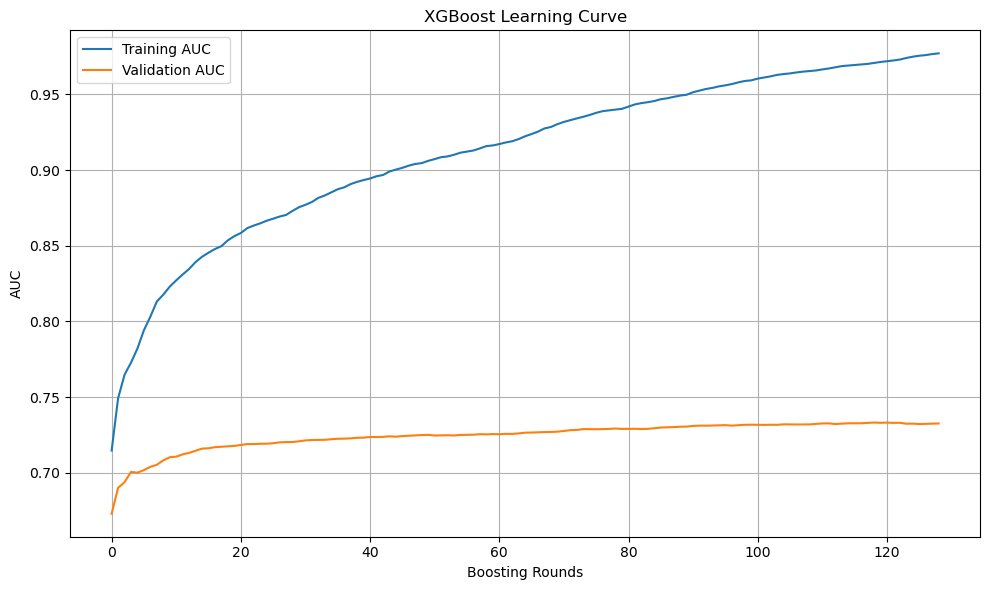

In [5]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['auc'], label='Training AUC')
plt.plot(evals_result['validation']['auc'], label='Validation AUC')
plt.title('XGBoost Learning Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# === Step 4: Generate Prediction Results ===
# Get predictions on validation data
val_probs = final_model.predict(dval)
val_preds = [1 if prob > 0.5 else 0 for prob in val_probs]

# Store results in a DataFrame 
results_df_xg = pd.DataFrame({
    "true_label": y_val,
    "predicted_label": val_preds,
    "probability_0": 1 - val_probs,  # Probability for class 0
    "probability_1": val_probs       # Probability for class 1
})

# Save and preview results
results_df_xg.to_csv("xgboost_results.csv")
results_df_xg

,true_label,predicted_label,probability_0,probability_1
0,0,0,0.917909,0.082091
1,0,0,0.968525,0.031475
2,0,0,0.971809,0.028191
3,0,0,0.915567,0.084433
4,0,0,0.662305,0.337694
...,...,...,...,...
34851,1,0,0.636510,0.363490
34852,0,0,0.963835,0.036165
34853,0,0,0.852580,0.147420
34854,0,0,0.958556,0.041444


## 4. Evaluate the Model

Optimal threshold based on F1 score: 0.230

Comparing threshold values:

--- Evaluation on Test Data (0.5 threshold) ---
AUC-ROC:     0.6320
F1-Score:    0.1507
Precision:   0.1945
Recall:      0.1230
Confusion Matrix:
[[111056   6205]
 [ 10679   1498]]


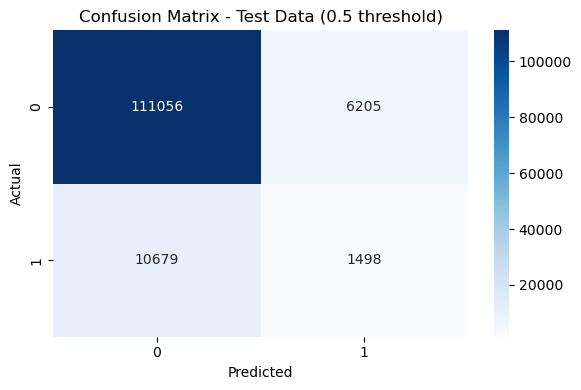

Using custom threshold of 0.3 for predictions

--- Evaluation on Test Data (0.3 threshold) ---
AUC-ROC:     0.6320
F1-Score:    0.2085
Precision:   0.1638
Recall:      0.2869
Confusion Matrix:
[[99428 17833]
 [ 8684  3493]]


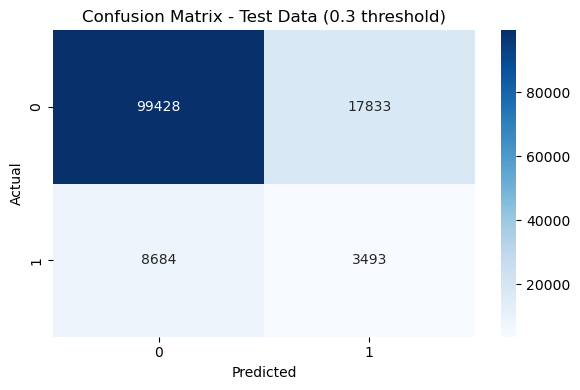

Using custom threshold of 0.2297300100326538 for predictions

--- Evaluation on Test Data (optimal: 0.230) ---
AUC-ROC:     0.6320
F1-Score:    0.2174
Precision:   0.1518
Recall:      0.3825
Confusion Matrix:
[[91237 26024]
 [ 7519  4658]]


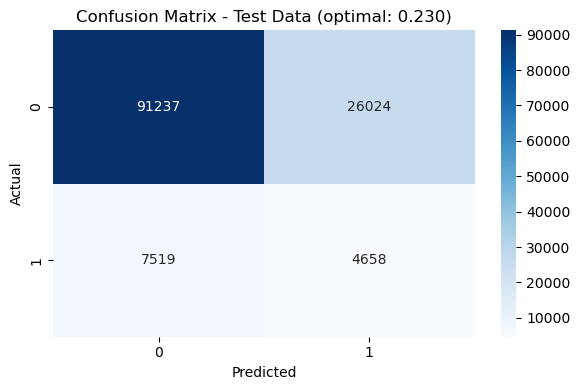

In [7]:
# === Step 5: Evaluate Model ===
def evaluate_model(model, X, y, dataset_name="", threshold=0.5):
    dmatrix = xgb.DMatrix(X)
    y_prob = model.predict(dmatrix)
    
    # Using a custom threshold (might help with imbalanced classes)
    if threshold != 0.5:
        print(f"Using custom threshold of {threshold} for predictions")
    
    # Convert probabilities to binary predictions
    y_pred = [1 if prob > threshold else 0 for prob in y_prob]
    
    # Calculate key metrics
    auc = roc_auc_score(y, y_prob)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Print results
    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    
    return auc, f1, precision, recall

# Find the optimal threshold based on precision-recall trade-off
from sklearn.metrics import precision_recall_curve
import numpy as np

# Calculate precision and recall for various thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)

# Calculate F1 score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = f1_scores[:-1]  # Align with thresholds array length

# Find threshold that maximizes F1
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold based on F1 score: {optimal_threshold:.3f}")

# Let's evaluate with both thresholds for comparison
print("\nComparing threshold values:")
standard_metrics = evaluate_model(final_model, X_test, y_test, "Test Data (0.5 threshold)", 0.5)
lstm_metrics = evaluate_model(final_model, X_test, y_test, "Test Data (0.3 threshold)", 0.3)
optimal_metrics = evaluate_model(final_model, X_test, y_test, f"Test Data (optimal: {optimal_threshold:.3f})", optimal_threshold)

<Figure size 1200x800 with 0 Axes>

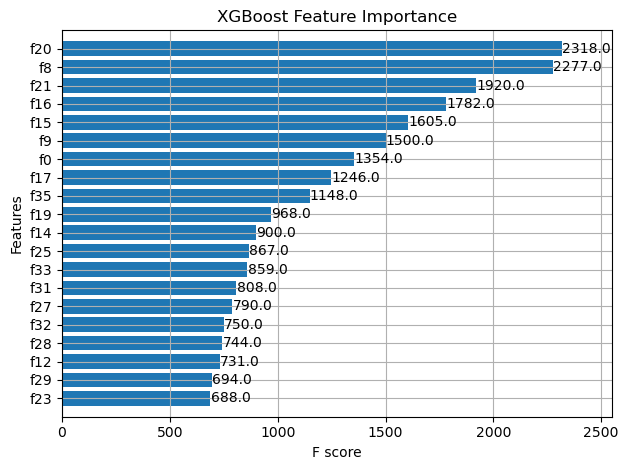


Top 10 Most Important Features:
  Feature  Importance
0      f1   19.211601
1      f2   17.423178
2     f12    5.719809
3     f15    5.222290
4      f3    5.113722
5     f17    4.971056
6     f24    4.706406
7     f32    4.651340
8     f35    4.480807
9     f28    4.480753


In [8]:
# === Step 6: Feature Importance Analysis ===
# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, max_num_features=20, height=0.8)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Get feature names and importance values
feature_importance = final_model.get_score(importance_type='gain')

# Create a list of tuples with feature names and importance scores
feature_tuples = [(k, v) for k, v in feature_importance.items()]

# Sort by importance
sorted_features = sorted(feature_tuples, key=lambda x: x[1], reverse=True)

# Convert to dataframe for better display
importance_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])

# Print top 10 important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

In [9]:
# === Step 7: Results Comparison ===
# Summarise key metrics on test data for comparison with other models
print("\n=== Model Comparison Summary ===")
print(f"XGBoost Test AUC (0.5 threshold):           {standard_metrics[0]:.4f}")
print(f"XGBoost Test F1 (0.5 threshold):            {standard_metrics[1]:.4f}")
print(f"XGBoost Test Recall (0.5 threshold):        {standard_metrics[3]:.4f}")
print(f"XGBoost Test Precision (0.5 threshold):     {standard_metrics[2]:.4f}")
print("\n")
print(f"XGBoost Test AUC (0.3 threshold):           {lstm_metrics[0]:.4f}")
print(f"XGBoost Test F1 (0.3 threshold):            {lstm_metrics[1]:.4f}")
print(f"XGBoost Test Recall (0.3 threshold):        {lstm_metrics[3]:.4f}")
print(f"XGBoost Test Precision (0.3 threshold):     {lstm_metrics[2]:.4f}")
print("\n")
print(f"XGBoost Test AUC (optimal threshold):       {optimal_metrics[0]:.4f}")
print(f"XGBoost Test F1 (optimal threshold):        {optimal_metrics[1]:.4f}")
print(f"XGBoost Test Recall (optimal threshold):    {optimal_metrics[3]:.4f}")
print(f"XGBoost Test Precision (optimal threshold): {optimal_metrics[2]:.4f}")


=== Model Comparison Summary ===
XGBoost Test AUC (0.5 threshold):           0.6320
XGBoost Test F1 (0.5 threshold):            0.1507
XGBoost Test Recall (0.5 threshold):        0.1230
XGBoost Test Precision (0.5 threshold):     0.1945


XGBoost Test AUC (0.3 threshold):           0.6320
XGBoost Test F1 (0.3 threshold):            0.2085
XGBoost Test Recall (0.3 threshold):        0.2869
XGBoost Test Precision (0.3 threshold):     0.1638


XGBoost Test AUC (optimal threshold):       0.6320
XGBoost Test F1 (optimal threshold):        0.2174
XGBoost Test Recall (optimal threshold):    0.3825
XGBoost Test Precision (optimal threshold): 0.1518
